# Test application of random forest model

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import random
from typing import List

from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV, RFE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import graphviz
import matplotlib.pyplot as plt

from src.data_utils import get_outlier_iqr

## Define constants

In [22]:
VARIABLE = 'N.Percent'
VARS = [
    'N.Percent',
    'P.Percent',
    'K.Percent',
    'Ca.Percent',
    'Mg.Percent',
    'C.Percent',
    'Amax',
    'Asat',
    'Area.cm2',
    'Dry.mass.g',
    'Fresh.mass.g',
    'Thickness.mm',
    'SLA.g.m2'
]
CENTRAL_WAVELENTGHS = {
    'B2_real': 490,
    'B3_real': 560,
    'B4_real': 665,
    'B5_real': 705,
    'B6_real': 740,
    'B7_real': 783,
    'B8_real': 842,
    'B11_real': 1610,
    'B12_real': 2190
}

## Define utility functions for exploring predictor variables

In [3]:
def get_sorted_feature_importances(model, ordered_cols) -> pd.DataFrame:
    """Return sorted features importances as a DataFrame."""
    importances = model.feature_importances_
    feature_importances = pd.DataFrame(importances, index=ordered_cols, columns=["Importance"])
    feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
    return feature_importances

In [96]:
def plot_residuals(y_test: pd.DataFrame, predictions: pd.DataFrame, var: str):
    """Plot residuals."""
    residuals = y_test.astype(np.float32) - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals)
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title(var)
    return plt.gca()

def plot_decision_trees(rf: BaseEstimator, features: List[str], no_of_trees: int):
    random_trees = random.sample(rf.estimators_, k=no_of_trees)

    for tree in random_trees:
        dot_data = export_graphviz(tree,
                                feature_names=features,  
                                filled=True,  
                                max_depth=2, 
                                impurity=False, 
                                proportion=True)
        graph = graphviz.Source(dot_data)
        display(graph)

In [5]:
def fit_predict_rf(X, y, verbose=True):
    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the RandomForestRegressor model.
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict the trait values
    predictions = rf.predict(X_test)

    # Calculate metrics.
    r_squared = rf.score(X_test, y_test)
    rmse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100

    if verbose:
        print(f"R-squared: {r_squared:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Mean Absolute Percentage Error: {mape:.1f}%")

        plot_residuals(y_test, predictions)

    return rf, [r_squared, rmse, mae, mape]

In [6]:
dpath = Path('/Users/campbelli/Documents/mini-project/data')
df = pd.read_csv(dpath / 'Master_Table_Modelling_LOWCORRELATIONS_wB8A.csv')
# Select only the pixels with 70% of the basal area covered and only community-weighted means.
cwms = df[(df['PercentCovered'] == '70') & (df['Type'] == 'CWMean')]
cwms.loc[:, 'TraitValue'] = pd.to_numeric(cwms['TraitValue'], errors='raise')
var_cwm = cwms[cwms['variable'] == VARIABLE]

/var/folders/g5/h0yjdszs0pz_qr3k5z8bjjq80000gp/T/ipykernel_6547/3735458380.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dpath / 'Master_Table_Modelling_LOWCORRELATIONS_wB8A.csv')


In [7]:
# All commented variables don't seem to be included in the paper.
# ** indicates same value for all pixels in a plot.
bands = [
    'B2_real', # Blue band, 490 nm
    'B3_real', # Green band, 560 nm
    'B4_real', # Red band, 665 nm
    'B5_real', # Red edge band, 705 nm
    'B6_real', # Red edge band, 740 nm
    'B7_real', # Red edge band, 783 nm
    'B8_real', # NIR band, 842 nm
    'B11_real', # SWIR band, 1610 nm
    'B12_real' # SWIR band, 2190 nm
]
spectral_indices = [
    'MCARI',
    'MCARI_Corr',
    'MCARI_Entropy',
    'MSAVI2', # (2 × NIR + 1 - √((2 × NIR + 1)² - 8 × (NIR - Red))) / 2
    'MSAVI2_Corr',
    'MSAVI2_Entropy',
    'NDRE', #  (NIR - RedEdge)/(NIR + RedEdge)
    'NDRE_Corr',
    'NDRE_Entropy',
]
climate_vars = [
    'CWD', # Climate Water Deficit
    'SoilMoist', # Soil Moisture
    'SRAD', # Solar irradiance
    'Tmax', # Mean annual maximum temperature
]
soil_vars = [
    'Slope', # Terrain slope
    'sand_perc_plot', # Sand content percentage
    'ph_h20_plot', # Soil pH in water 
    'clay_perc_plot', # Clay content percentage **
    'CEC_mmol_kg_plot', # Cation exchange capacity **
]

cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]

## Test application of random forest regression model
### Baseline: use a number of randomly selected variables


In [10]:
# Repeat experiment with ranadomly initialized data for mean R^2 score
n_samples = 1000
n_features = len(bands)
n_iterations = 30

y = var_cwm[ 'TraitValue'][:n_samples]

r_squared_scores = []
rmse_scores = []
mape_scores = []

for i in range(n_iterations):
    X = np.random.randn(n_samples, n_features)
    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Initialize the RandomForestRegressor model.
    estimator = RandomForestRegressor(n_estimators=100, random_state=i)
    rf = Pipeline(
        [
        ("estimator", estimator)]
    )

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict the trait values
    predictions = rf.predict(X_test)

    # Calculate metrics.
    r_squared_scores.append(rf.score(X_test, y_test))
    rmse_scores.append(root_mean_squared_error(y_test, predictions))
    mape_scores.append(mean_absolute_percentage_error(y_test, predictions) * 100)

print(f"R-squared: {np.mean(r_squared_scores):.2f}")
print(f"RMSE: {np.mean(rmse_scores):.2f}")
print(f"MAPE: {np.mean(mape_scores):.1f}%")

R-squared: -0.09
RMSE: 0.70
MAPE: 25.0%


### Use raw bands only

See what information can be extracted from the raw reflectances when treating the bands as independent explainer variables.

R-squared: 0.39
Root Mean Squared Error: 0.50
Mean Absolute Error: 0.28
Mean Absolute Percentage Error: 12.7%


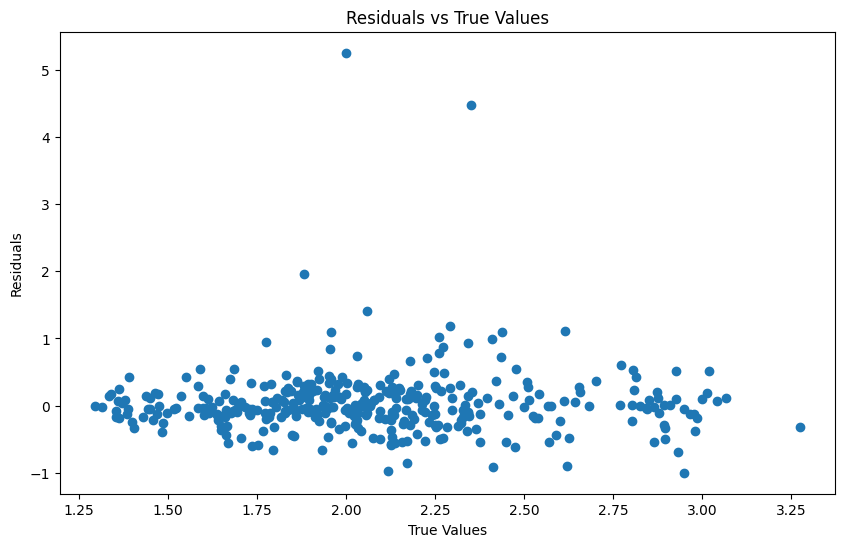

In [11]:
# Remove rows with missing band data.
X = var_cwm[bands].dropna(axis=0)
y = var_cwm.loc[X.index.values, 'TraitValue']

rf, _ = fit_predict_rf(X, y)

In [14]:
get_sorted_feature_importances(rf, X.columns).head(10)

,Importance
B12_real,0.289657
B2_real,0.204021
B11_real,0.085077
B5_real,0.083227
B8_real,0.080856
B4_real,0.077130
B7_real,0.061198
B3_real,0.059450
B6_real,0.059383


### Remove outliers by location and re-run regression

In [15]:
var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index().drop(columns='level_1', axis=1)

,Location,TraitValue
0,Australia,2.79
1,Ghana,6.821242
2,Ghana,6.767072
3,Ghana,7.331787
4,Ghana,7.255256
5,Malaysia,3.474985
6,Malaysia,3.499841


R-squared: 0.56
Root Mean Squared Error: 0.35
Mean Absolute Error: 0.26
Mean Absolute Percentage Error: 13.3%


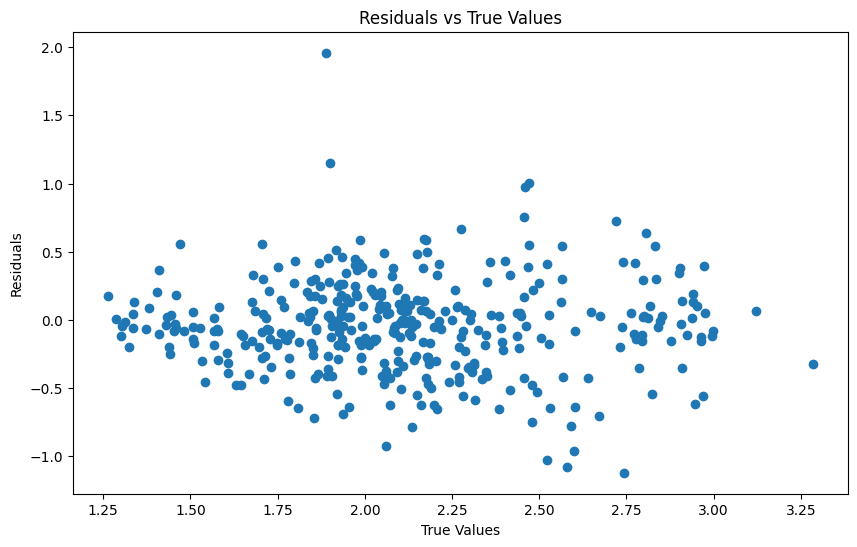

In [19]:
# Remove outliers from the dataset.
outlier_indices = var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['level_1']
X = var_cwm.drop(outlier_indices)

# Remove rows with missing band data.
X = X[bands].dropna(axis=0)
y = var_cwm.loc[X.index.values, 'TraitValue']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf, _ = fit_predict_rf(X, y)

In [20]:
get_sorted_feature_importances(rf, X.columns).head(10)

,Importance
B12_real,0.286051
B2_real,0.211036
B11_real,0.094477
B5_real,0.083806
B8_real,0.083732
B4_real,0.066673
B7_real,0.060402
B6_real,0.058811
B3_real,0.055010


### Use auxiliary variables as well as raw bands information.

R-squared: 0.67
Root Mean Squared Error: 0.30
Mean Absolute Error: 0.22
Mean Absolute Percentage Error: 11.2%


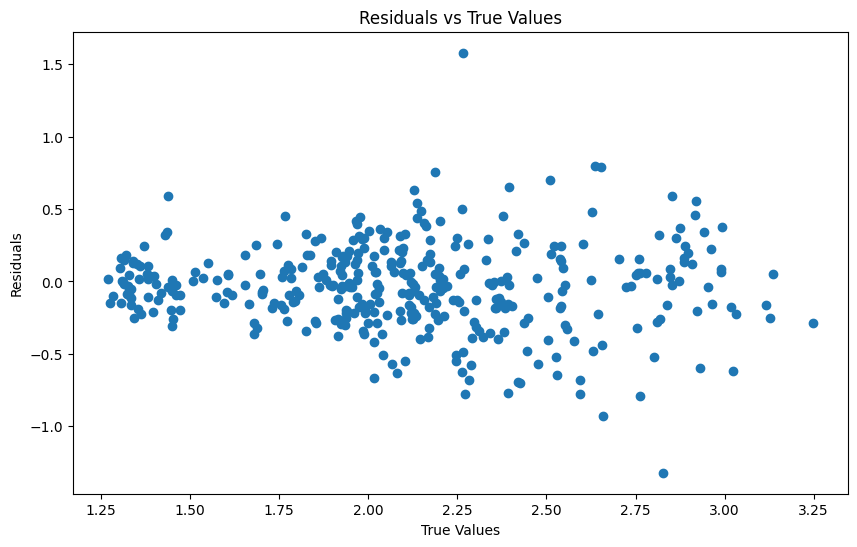

In [21]:
# Remove rows with missing band data.
cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]
X = var_cwm.drop(var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['level_1'])
X = X[cols].dropna(axis=0)
y = var_cwm.loc[X.index.values, 'TraitValue']

rf, _ = fit_predict_rf(X, y)

In [22]:
get_sorted_feature_importances(rf, X.columns).head(10)

,Importance
SoilMoist,0.160435
SRAD,0.155486
CWD,0.139036
ph_h20_plot,0.135572
MSAVI2,0.037290
clay_perc_plot,0.031311
NDRE_Entropy,0.029576
MCARI_Corr,0.028805
MSAVI2_Entropy,0.027080
MSAVI2_Corr,0.025742


Now, no spectral bands are important in making predictions...

### Grid search over hyperparameters for RF with bands only

Test many hyperparameter combinations to see which is best.

In [24]:
from sklearn.model_selection import GridSearchCV

from src.data_utils import LabelledTraitData
from models.rf_bands_only import RFBandsOnly
from models.rf_aux_vars import RFAuxAndBands

In [57]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Ensure that the data being used is the same as that used in the automated evaluation framework. The data has had outliers removed from trait values using the IQR-based approach, and has also been standardised.

In [58]:
bands_only_best_params = {}
bands_only_best_estimators = {}

for var in VARS:
    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_train, y_train = dataset.train_data, dataset.train_labels
    X_test, y_test = dataset.test_data, dataset.test_labels

    X_train, y_train = RFBandsOnly.configure_data(X_train, y_train)
    X_test, y_test = RFBandsOnly.configure_data(X_test, y_test)

    # Initialize GridSearchCV
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    bands_only_best_params[var] = grid_search.best_params_
    bands_only_best_estimators[var] = grid_search.best_estimator_

In [90]:
# Count the best parameters for each variable
param_counts = {}
for var, params in bands_only_best_params.items():
    for param, value in params.items():
        dataset = LabelledTraitData(
            data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
            var=var
        )
        X_test, y_test = RFBandsOnly.configure_data(dataset.test_data, dataset.test_labels)

        # Weight value by estimator score
        best_score = bands_only_best_estimators[var].score(X_test, y_test)
        if param in param_counts:
            if value in param_counts[param]:
                param_counts[param][value] += best_score
            else:
                param_counts[param][value] = best_score
        else:
            param_counts[param] = {value: best_score}

# Get the most common parameter values weighted by score.
sorted_params = {param: sorted(val.items(), key=lambda x: x[1], reverse=True) for param, val in param_counts.items()}
for param, values in sorted_params.items():
    print(f"Best value for {param}: {values[0][0]} with score {values[0][1]:.2f}")

bands_only_optim_params = {par: val[0][0] for par, val in sorted_params.items()}

Best value for max_depth: 15 with score 3.32
Best value for max_features: 0.5 with score 3.35
Best value for min_samples_leaf: 1 with score 3.68
Best value for min_samples_split: 2 with score 4.23
Best value for n_estimators: 100 with score 2.01


In [91]:
bands_only_optim_params

{'max_depth': 15,
 'max_features': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
R-squared: 0.65


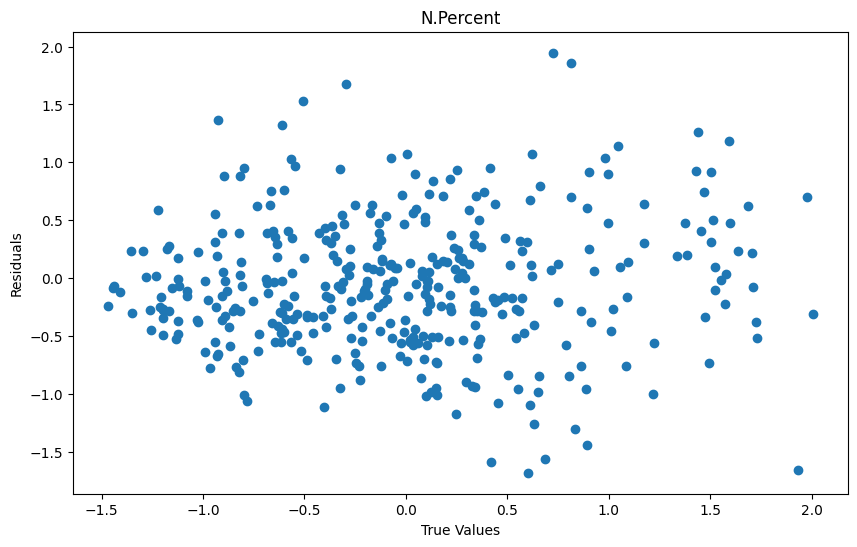

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
R-squared: 0.49


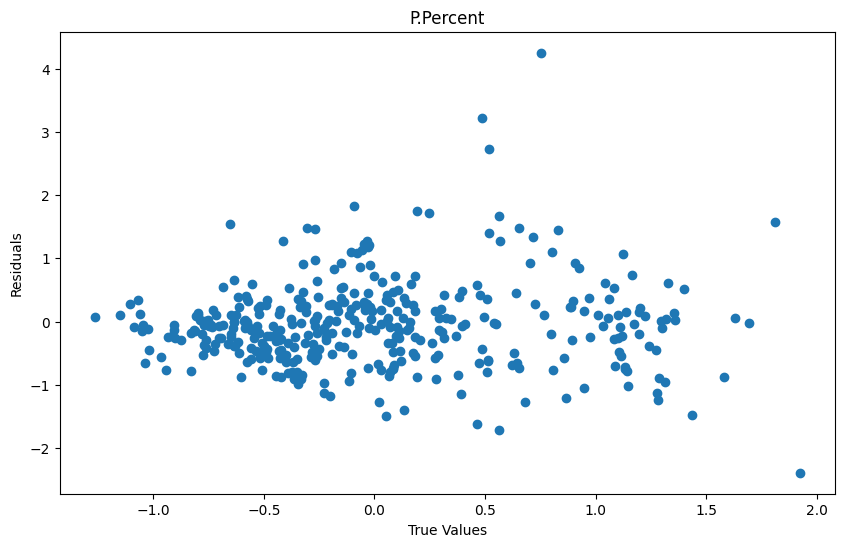

Best parameters: {'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
R-squared: 0.38


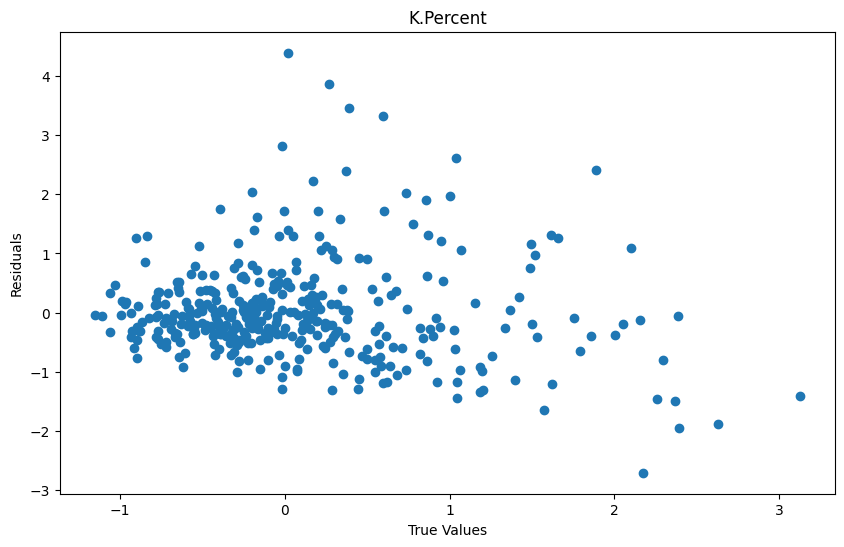

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R-squared: 0.76


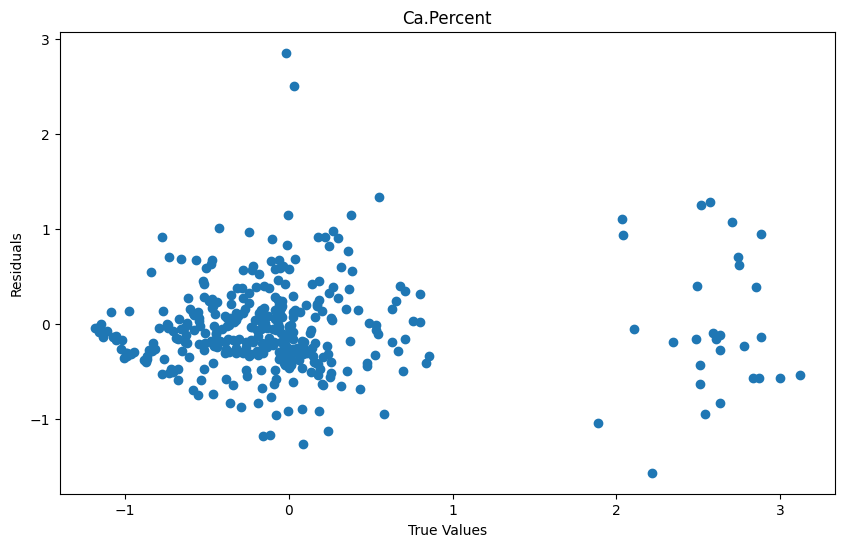

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R-squared: 0.27


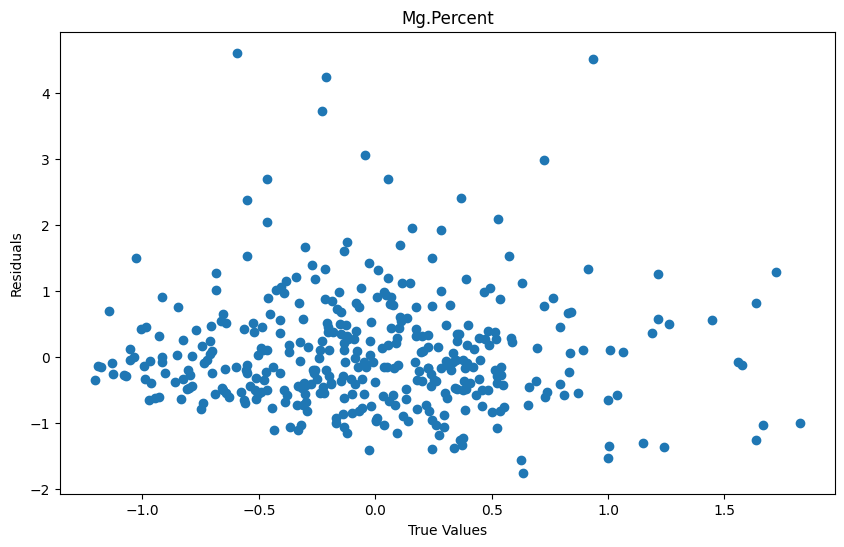

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R-squared: 0.54


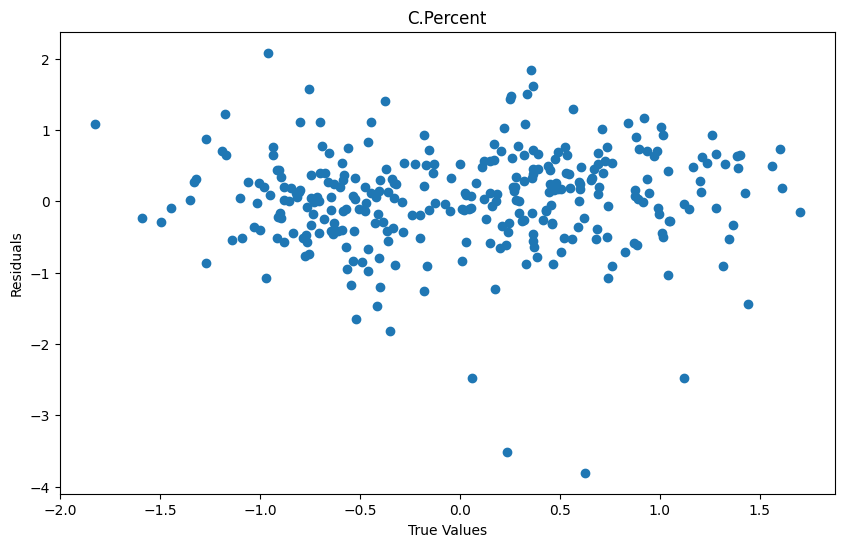

Best parameters: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
R-squared: 0.63


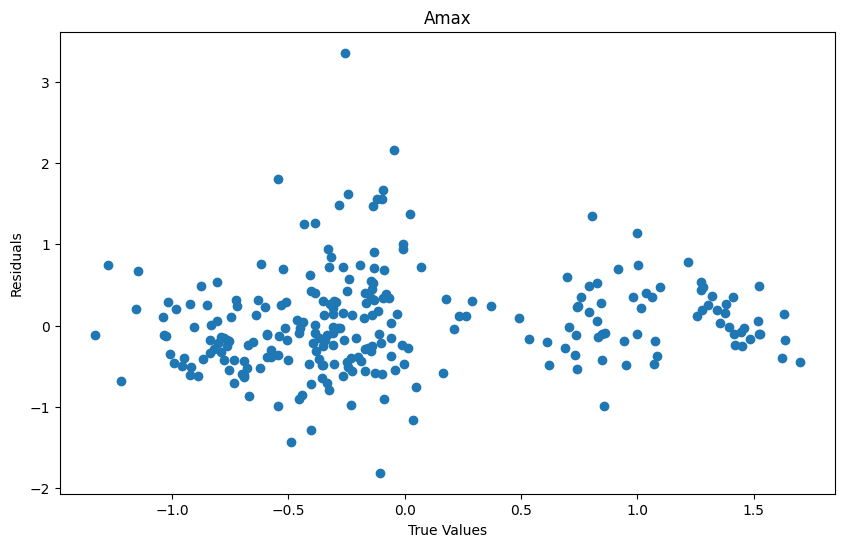

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
R-squared: 0.42


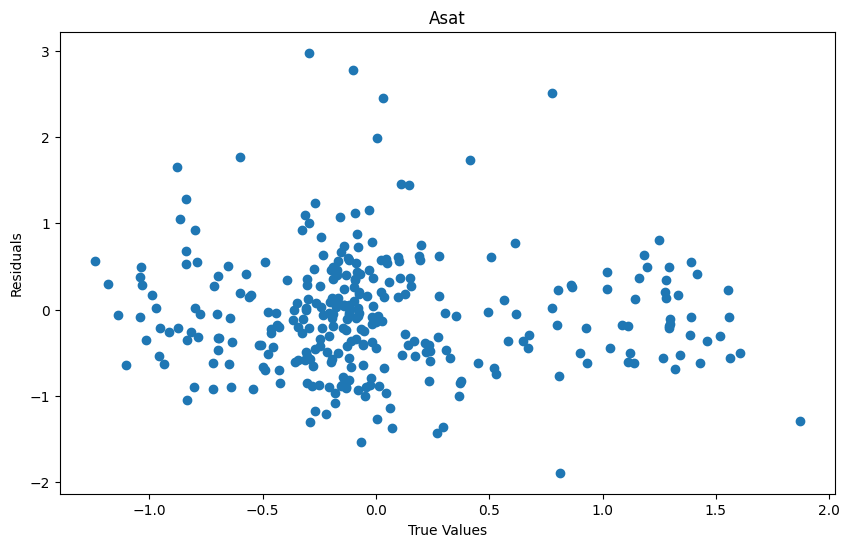

Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
R-squared: 0.35


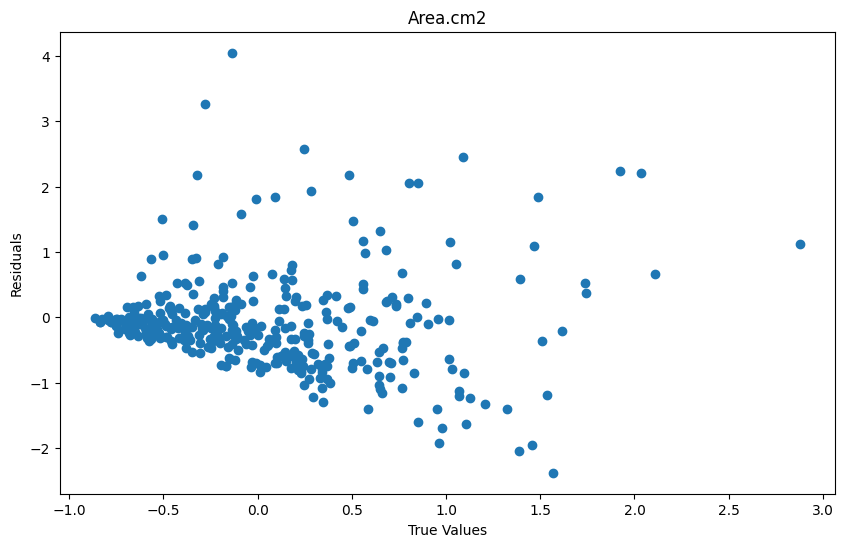

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
R-squared: 0.13


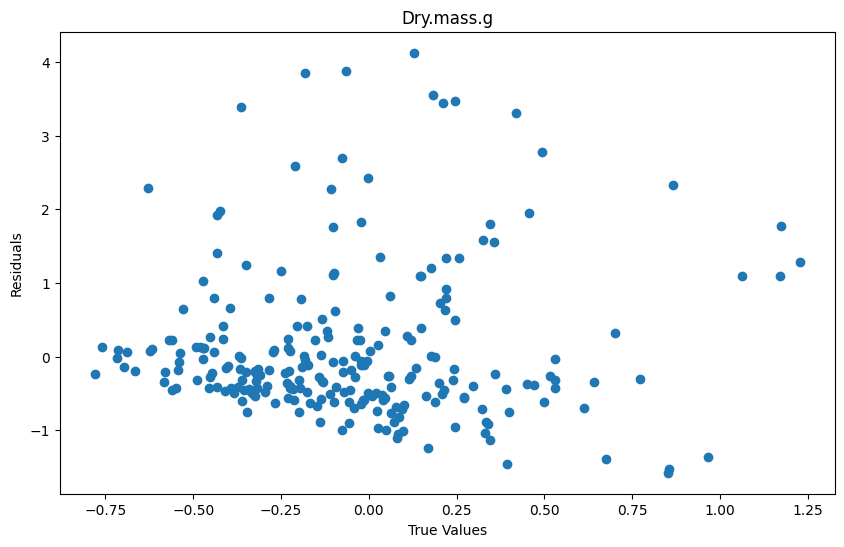

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
R-squared: 0.19


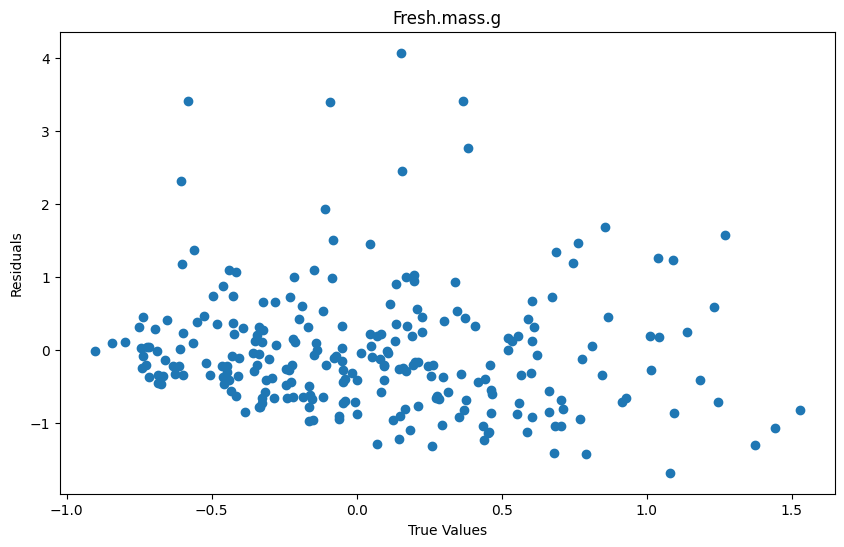

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
R-squared: 0.44


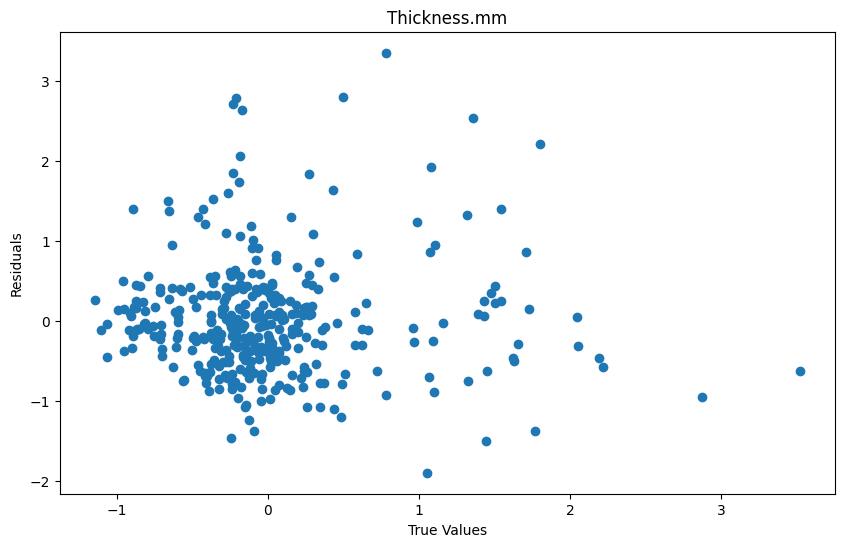

Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
R-squared: 0.30


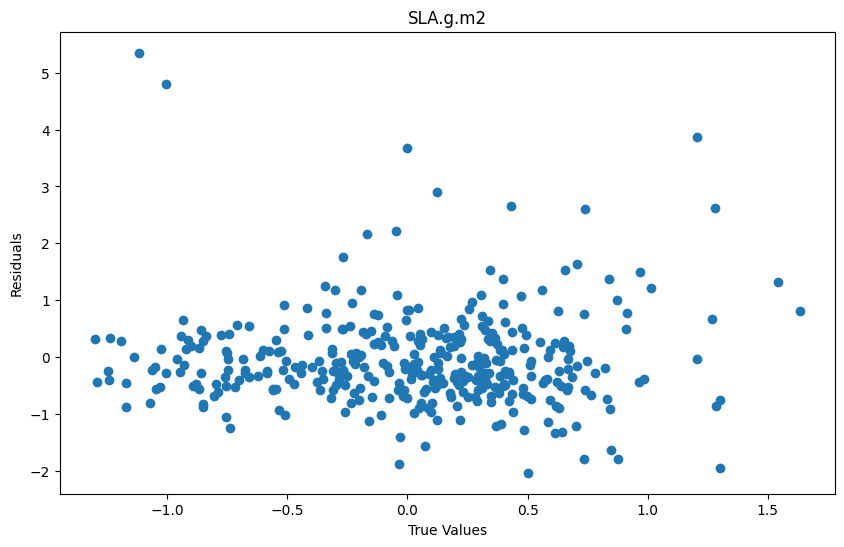

In [98]:
for var in VARS:
    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_test, y_test = RFBandsOnly.configure_data(dataset.test_data, dataset.test_labels)

    # Get the best parameters
    best_params = bands_only_best_params[var]
    print(f"Best parameters: {best_params}")
    # Get the best model
    best_rf = bands_only_best_estimators[var]
    # Predict the trait values
    predictions = best_rf.predict(X_test)
    # Calculate metrics.
    r_squared = best_rf.score(X_test, y_test)
    print(f"R-squared: {r_squared:.2f}")

    fig = plot_residuals(y_test, predictions, var)
    plt.savefig(f"../figures/models/residuals_{var}_RFbandsonly.png")
    plt.show()

### Perform the same grid search cross-validation for the model including auxiliary variables

In [63]:
aux_too_best_params = {}
aux_too_best_estimators = {}

for var in VARS:
    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_train, y_train = dataset.train_data, dataset.train_labels
    X_test, y_test = dataset.test_data, dataset.test_labels

    X_train, y_train = RFAuxAndBands.configure_data(X_train, y_train)
    X_test, y_test = RFAuxAndBands.configure_data(X_test, y_test)

    # Initialize GridSearchCV
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    aux_too_best_params[var] = grid_search.best_params_
    aux_too_best_estimators[var] = grid_search.best_estimator_

In [101]:
# Count the best parameters for each variable
param_counts = {}
for var, params in aux_too_best_params.items():
    for param, value in params.items():
        dataset = LabelledTraitData(
            data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
            var=var
        )
        X_test, y_test = RFAuxAndBands.configure_data(dataset.test_data, dataset.test_labels)

        # Weight value by estimator score
        best_score = aux_too_best_estimators[var].score(X_test, y_test)
        if param in param_counts:
            if value in param_counts[param]:
                param_counts[param][value] += best_score
            else:
                param_counts[param][value] = best_score
        else:
            param_counts[param] = {value: best_score}

# Get the most common parameter values weighted by score.
# Get the most common parameter values weighted by score.
sorted_params = {param: sorted(val.items(), key=lambda x: x[1], reverse=True) for param, val in param_counts.items()}
for param, values in sorted_params.items():
    print(f"Best value for {param}: {values[0][0]} with score {values[0][1]:.2f}")

aux_too_optim_params = {par: val[0][0] for par, val in sorted_params.items()}

Best value for max_depth: 15 with score 3.73
Best value for max_features: log2 with score 3.38
Best value for min_samples_leaf: 2 with score 4.03
Best value for min_samples_split: 2 with score 5.08
Best value for n_estimators: 200 with score 2.80


In [102]:
aux_too_optim_params

{'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
R-squared: 0.75


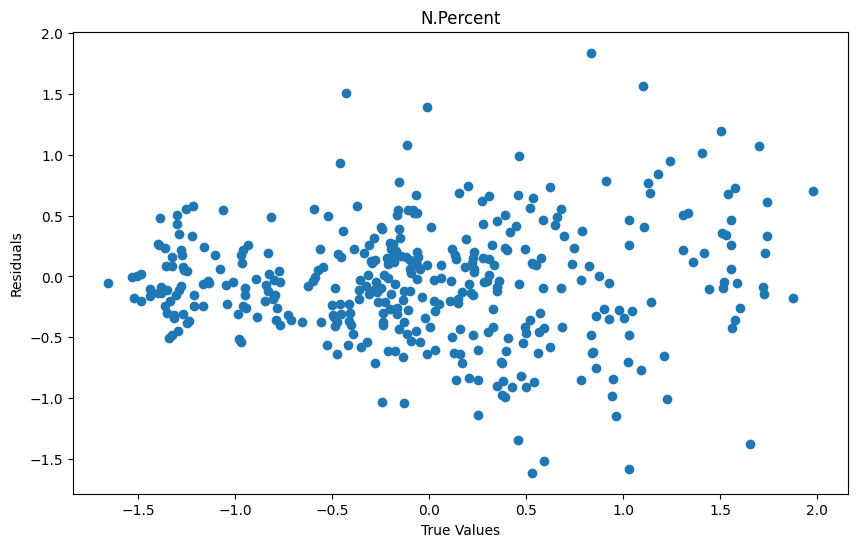

Best parameters: {'max_depth': 15, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
R-squared: 0.65


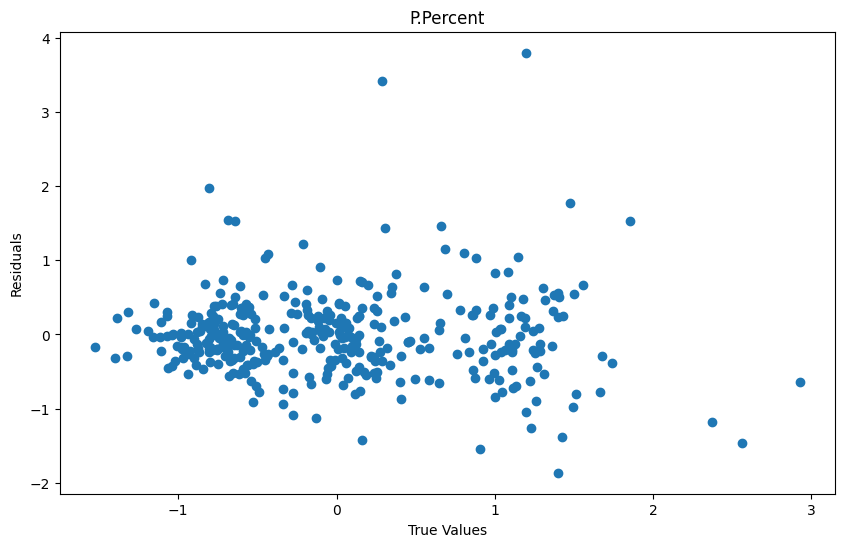

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
R-squared: 0.51


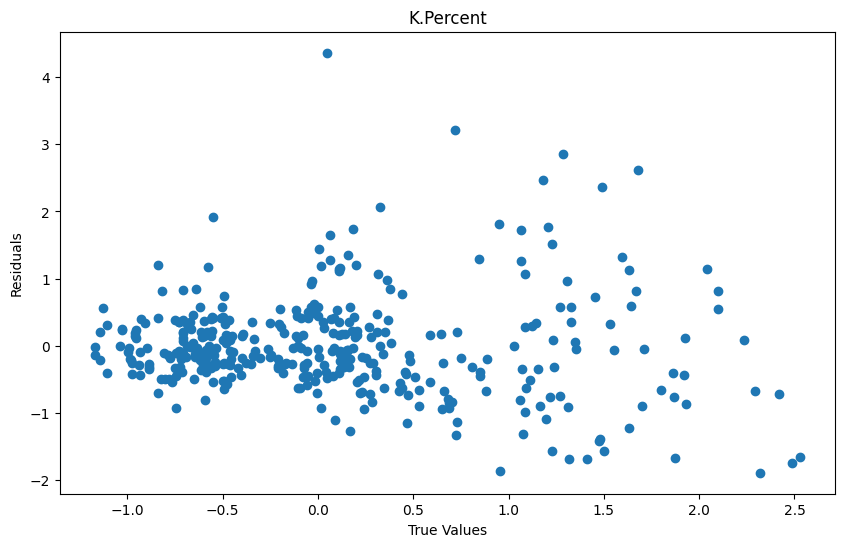

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
R-squared: 0.82


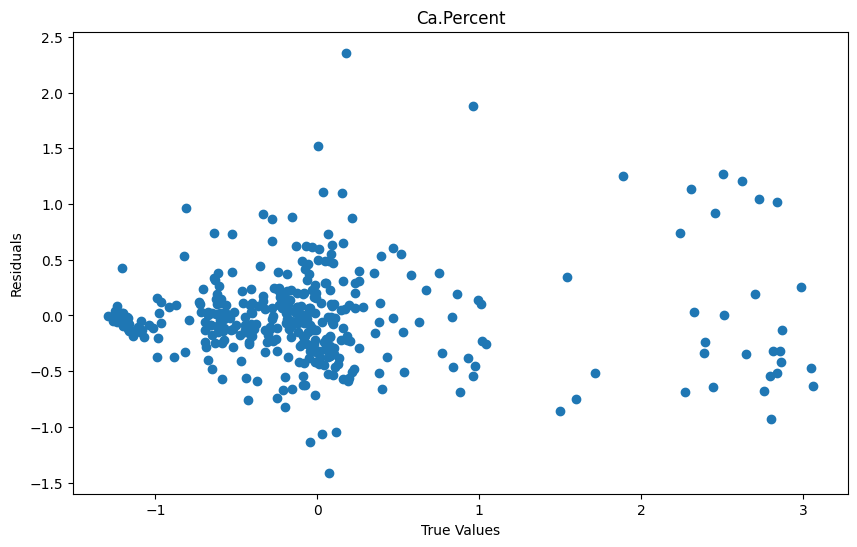

Best parameters: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R-squared: 0.48


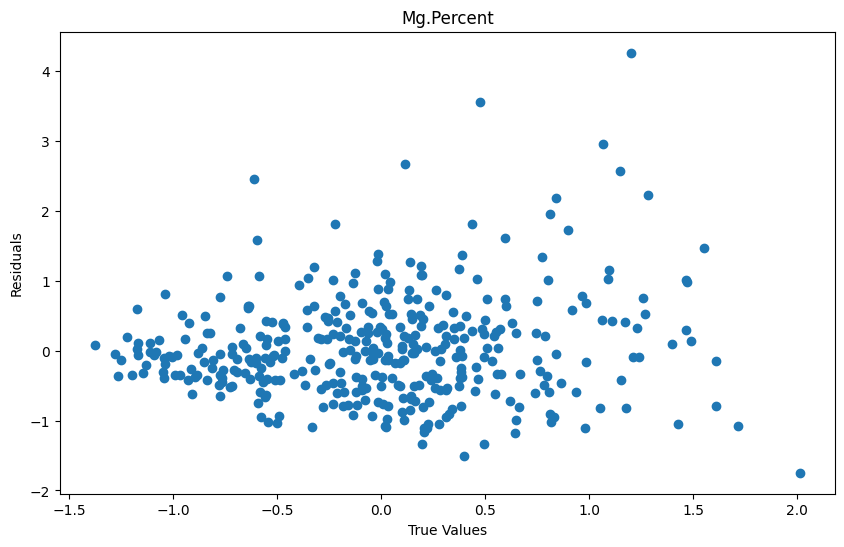

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R-squared: 0.61


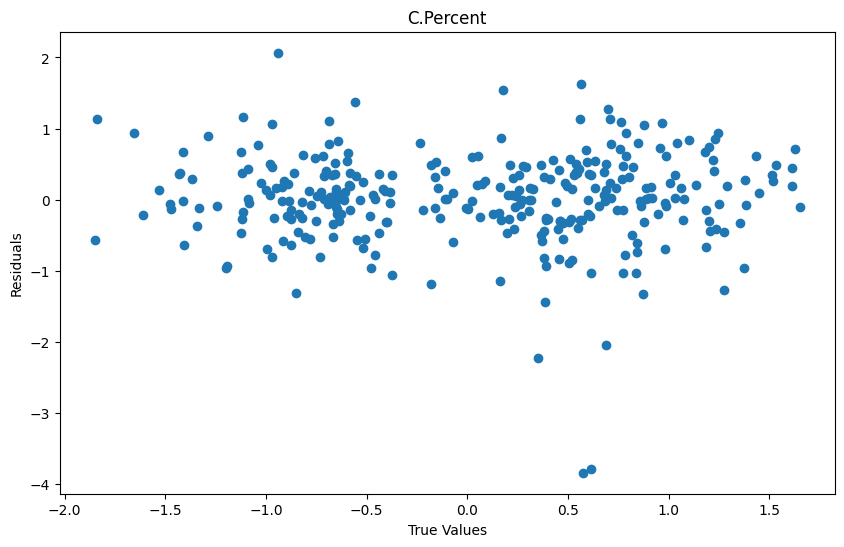

Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
R-squared: 0.70


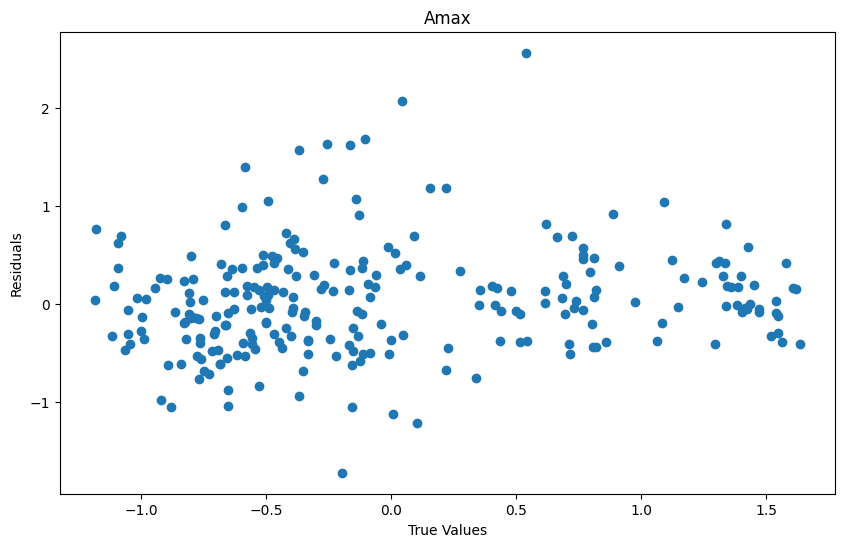

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
R-squared: 0.52


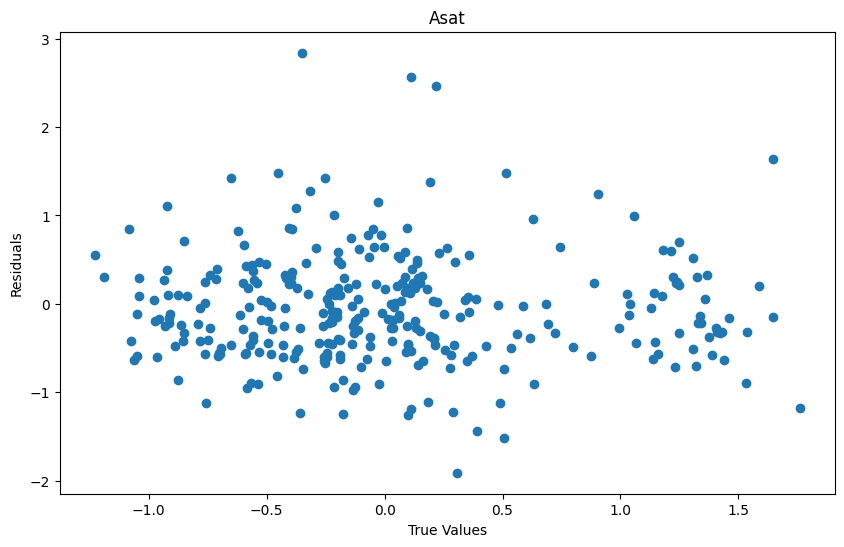

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R-squared: 0.48


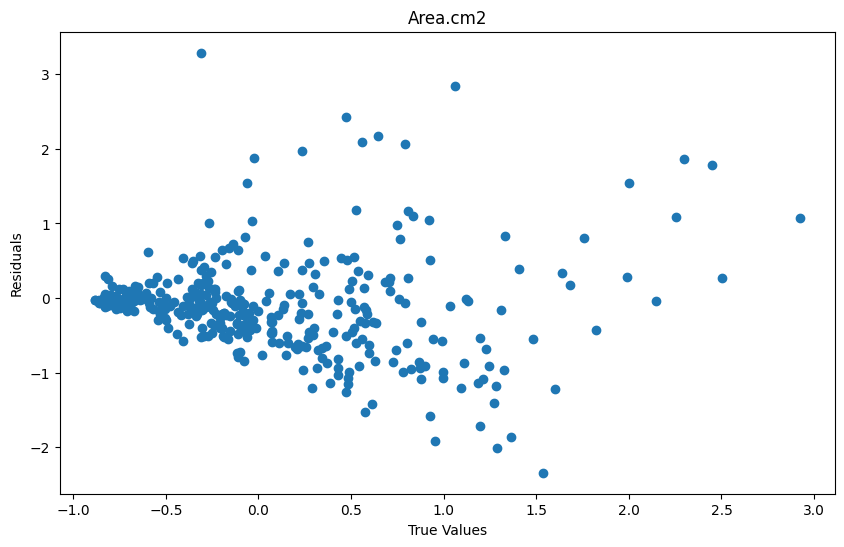

Best parameters: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
R-squared: 0.18


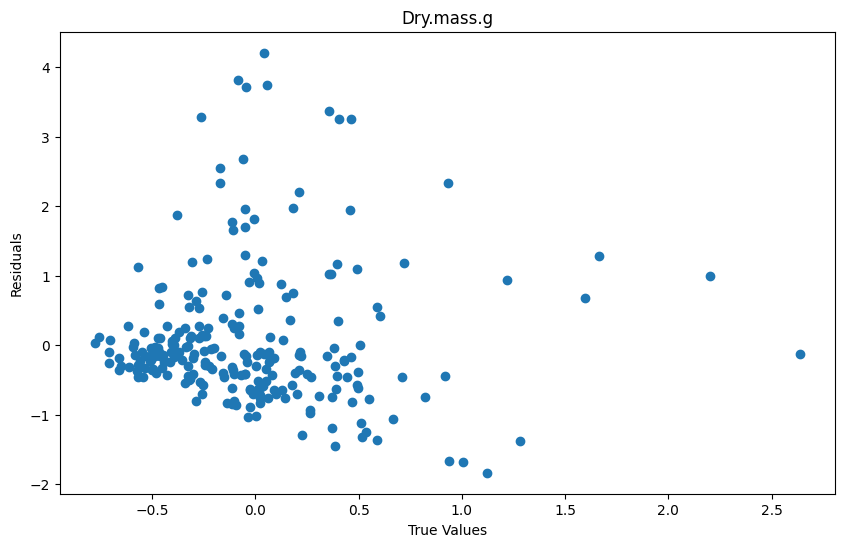

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
R-squared: 0.31


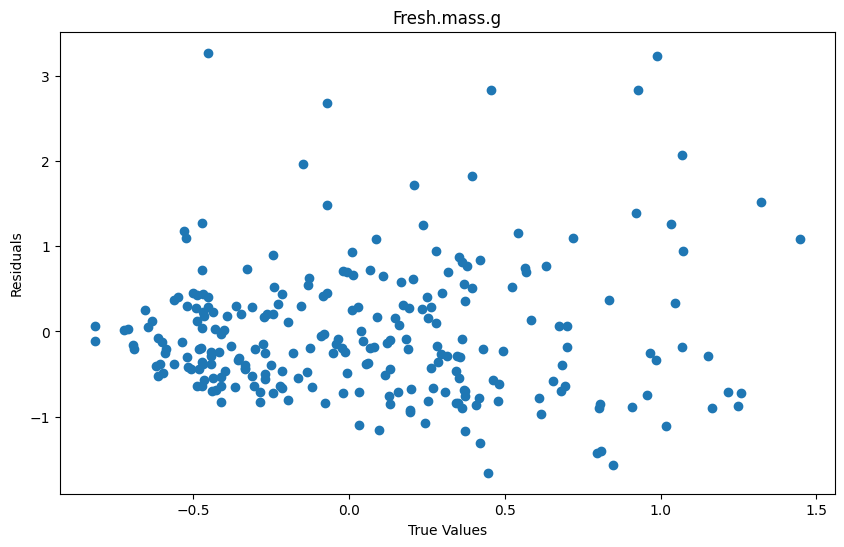

Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
R-squared: 0.59


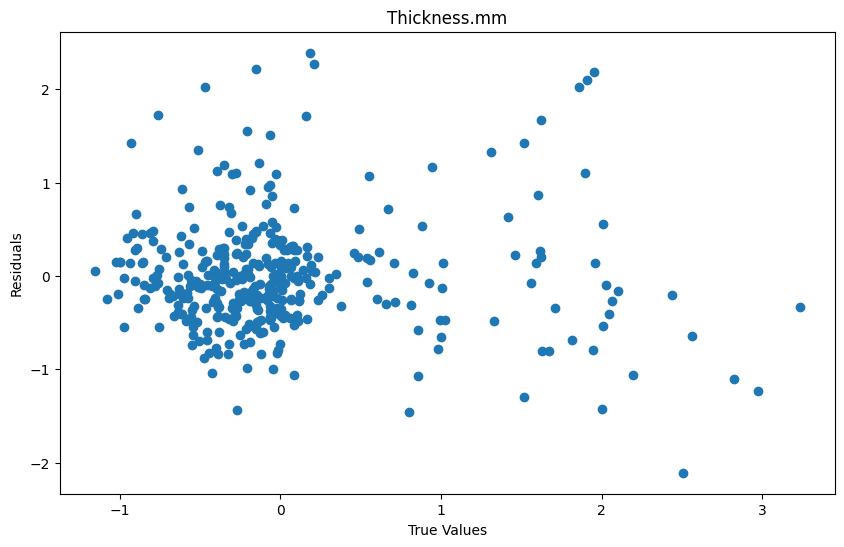

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
R-squared: 0.39


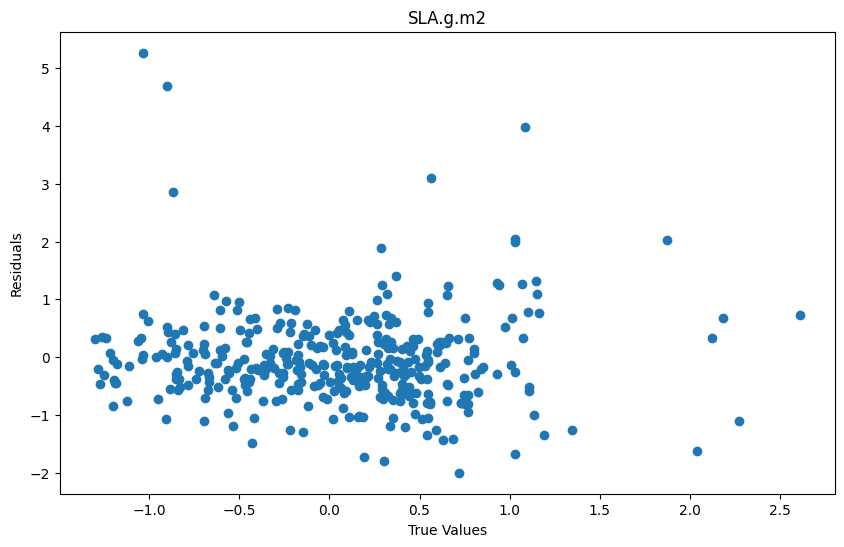

In [99]:
for var in VARS:
    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_test, y_test = RFAuxAndBands.configure_data(dataset.test_data, dataset.test_labels)

    # Get the best parameters
    best_params = aux_too_best_params[var]
    print(f"Best parameters: {best_params}")
    # Get the best model
    best_rf = aux_too_best_estimators[var]
    # Predict the trait values
    predictions = best_rf.predict(X_test)
    # Calculate metrics.
    r_squared = best_rf.score(X_test, y_test)
    print(f"R-squared: {r_squared:.2f}")

    fig = plot_residuals(y_test, predictions, var)
    plt.savefig(f"../figures/models/residuals_{var}_RFauxvars.png")
    plt.show()

### Condense bands into fewer variables
The bands are highly correlated with each other. We want to use only relevant information from the spectrum, but the raw bands have a lot of redundant information. We might try to mix the bands together somehow. 

We can use a PCA to create a few principl components along the major axes of variation that explain some $x$ amount of variance, let's say 95%. 

However, this is a linear method so assumes that the bands co-vary in a linear fashion, which is unlikely to be the case given the complicated interactions and interference phenomena between rays.

In [26]:
cols = ['S2B_PC1', 'S2B_PC2', 'S2B_PC3', *spectral_indices, *climate_vars, *soil_vars]

In [27]:
# Perform PCA on the bands to reduce multi-collinearity
# Standardize the data before PCA.
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(var_cwm[bands].dropna(axis=0))

# Perform PCA.
pca = PCA(n_components=3)
X_pca = pca.fit_transform(var_cwm[bands].dropna(axis=0))
pca_df = pd.DataFrame(data=X_pca, columns=[f'S2B_PC{i+1}' for i in range(X_pca.shape[1])]) # Double check the indices remain what I expect.
# Concatenate the PCA components with the original data.
pca_df = pd.concat([pca_df, var_cwm.reset_index(drop=True)], axis=1)
pca.explained_variance_ratio_

array([0.80084741, 0.11973089, 0.04920048])

R-squared: 0.67
Root Mean Squared Error: 0.30
Mean Absolute Error: 0.22
Mean Absolute Percentage Error: 11.2%


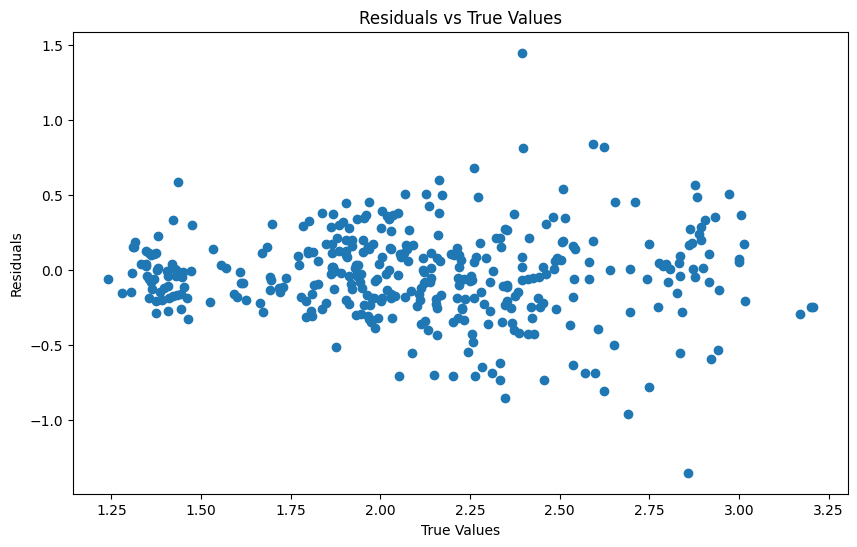

In [28]:
# Use PCA components instead of original bands.
X = pca_df.drop(pca_df.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['level_1'])
X = X[cols].dropna(axis=0)
y = pca_df.loc[X.index.values, 'TraitValue']

rf, _ = fit_predict_rf(X, y)

In [29]:
get_sorted_feature_importances(rf, X.columns).head(10)

,Importance
SRAD,0.175100
SoilMoist,0.146113
ph_h20_plot,0.145890
CWD,0.130257
MSAVI2,0.042576
MCARI_Corr,0.034514
MSAVI2_Entropy,0.033275
NDRE_Entropy,0.032440
MCARI_Entropy,0.031639
MSAVI2_Corr,0.030182


### Inspect how much variance is explained just by PCs

R-squared: 0.28
Root Mean Squared Error: 0.54
Mean Absolute Error: 0.33
Mean Absolute Percentage Error: 15.7%


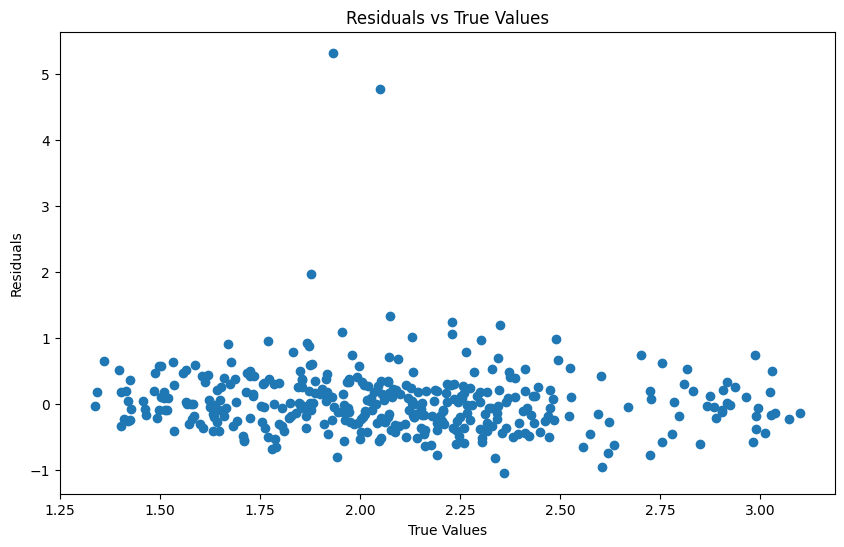

In [30]:
# Use PCA components instead of original bands.
cols = ['S2B_PC1', 'S2B_PC2', 'S2B_PC3']
X = pca_df[cols].dropna(axis=0)
y = pca_df.loc[X.index.values, 'TraitValue']

rf, _ = fit_predict_rf(X, y)

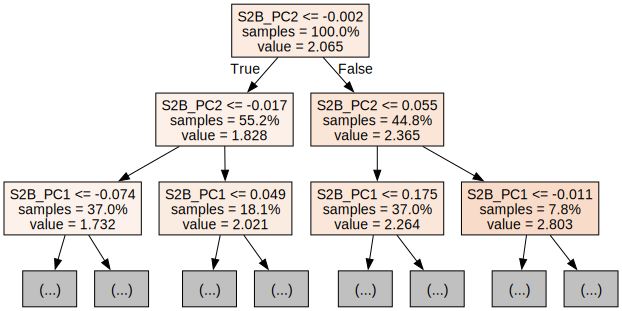

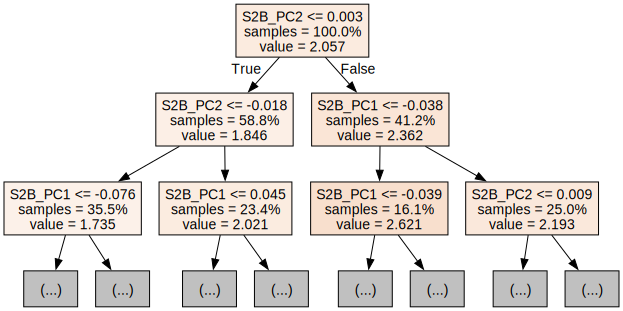

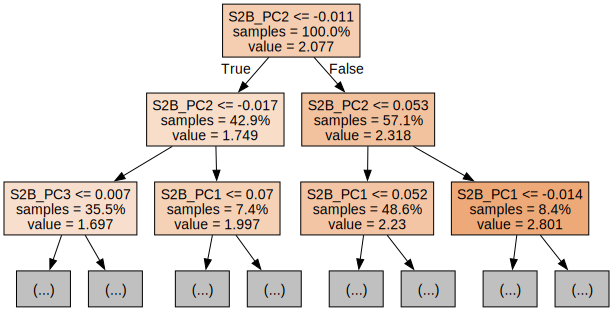

In [47]:
# Export the first three decision trees from the forest
no_of_trees = 3
plot_decision_trees(rf, cols, no_of_trees)

## Apply RF model to all variables

In [ ]:
traits = cwms.variable.unique()
r_squared_scores = []
rmse_scores = []
mae_scores = []
mape_scores = []

for trait in traits:
    var_cwm = cwms[cwms['variable'] == trait]
    cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]

    # Remove outliers from the dataset.
    outlier_indices = var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['level_1']
    X = var_cwm.drop(outlier_indices)
    # Remove rows with missing band data.
    X = X[cols].dropna(axis=0)
    y = var_cwm.loc[X.index.values, 'TraitValue']

    rf, metrics = fit_predict_rf(X, y, verbose=False)
    r_squared_scores.append(metrics[0])
    rmse_scores.append(metrics[1])
    mae_scores.append(metrics[2])
    mape_scores.append(metrics[3])

# Create a DataFrame to store the results
independent_scores = pd.DataFrame({
    'Trait': traits,
    'R-squared': r_squared_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'MAPE': mape_scores
}).set_index('Trait')

In [ ]:
independent_scores.sort_values(by='R-squared', ascending=False, inplace=True)
independent_scores

,R-squared,RMSE,MAE,MAPE
Trait,,,,
Ca.Percent,0.754648,0.311143,0.176920,25.231856
Amax,0.747756,3.064644,2.282733,26.144299
Thickness.mm,0.736050,0.052369,0.036844,12.708401
N.Percent,0.676958,0.299536,0.220839,11.068149
P.Percent,0.624369,0.020926,0.014273,14.330559
K.Percent,0.554195,0.226380,0.153235,18.848750
C.Percent,0.518645,1.858118,1.257614,2.704133
Asat,0.501172,1.440645,1.055133,27.091070
Area.cm2,0.496659,67.727828,39.196584,51.847838


In [ ]:
independent_scores.agg({'R-squared': 'mean', 'MAPE': 'mean'})

R-squared     0.542303
MAPE         24.510803
dtype: float64

## Inspect improvement in predictive power when auto-regressively predicting traits.

In [ ]:
traits = independent_scores.index.unique() # In order of best R^2
r_squared_scores = []
rmse_scores = []
mae_scores = []
mape_scores = []

for i, trait in enumerate(traits):
    var_cwm = cwms[cwms['variable'] == trait].set_index('New_Plot')
    cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]

    # Remove outliers from the dataset.
    outlier_indices = var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['New_Plot']
    X = var_cwm.drop(outlier_indices)[cols]

    if i == 0:
        preds_df = pd.DataFrame(index=X.index)
        feature_importances = pd.DataFrame()
    else:
        X = X.join(preds_df, how='inner', on='New_Plot')

    y = var_cwm.loc[X.index.values, 'TraitValue']

    rf, metrics = fit_predict_rf(X, y, verbose=False)
    r_squared_scores.append(metrics[0])
    rmse_scores.append(metrics[1])
    mae_scores.append(metrics[2])
    mape_scores.append(metrics[3])

    preds = pd.DataFrame(rf.predict(X), index=X.index, columns=[f'{trait}_pred'])
    preds_df = preds_df.join(preds, how='outer', on='New_Plot')

    feature_importance = get_sorted_feature_importances(rf.named_steps['estimator'], X.columns)[:10].index.values
    feature_importances = pd.concat([feature_importances, pd.DataFrame(feature_importance, columns=[trait])], axis=1)
    
# Create a DataFrame to store the results
interdependent_scores = pd.DataFrame({
    'Trait': traits,
    'R-squared': r_squared_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'MAPE': mape_scores
}).set_index('Trait')

In [ ]:
feature_importances

,Ca.Percent,Thickness.mm,Amax,N.Percent,P.Percent,K.Percent,C.Percent,Area.cm2,Asat,WD,Mg.Percent,SLA.g.m2,Dry.mass.g,Fresh.mass.g
0,ph_h20_plot,Tmax,sand_perc_plot,SoilMoist,Amax_pred,SRAD,SRAD,CWD,Amax_pred,P.Percent_pred,Ca.Percent_pred,Tmax,Area.cm2_pred,Dry.mass.g_pred
1,MSAVI2_Entropy,SoilMoist,ph_h20_plot,ph_h20_plot,N.Percent_pred,P.Percent_pred,Ca.Percent_pred,Amax_pred,MSAVI2_Corr,Area.cm2_pred,K.Percent_pred,Thickness.mm_pred,SLA.g.m2_pred,Area.cm2_pred
2,CEC_mmol_kg_plot,sand_perc_plot,Thickness.mm_pred,CWD,Ca.Percent_pred,SoilMoist,Amax_pred,N.Percent_pred,Ca.Percent_pred,CEC_mmol_kg_plot,Thickness.mm_pred,ph_h20_plot,Thickness.mm_pred,K.Percent_pred
3,NDRE_Corr,Ca.Percent_pred,MCARI_Corr,SRAD,ph_h20_plot,N.Percent_pred,Thickness.mm_pred,K.Percent_pred,C.Percent_pred,C.Percent_pred,P.Percent_pred,B4_real,Ca.Percent_pred,N.Percent_pred
4,MSAVI2_Corr,MCARI_Entropy,MSAVI2_Entropy,Thickness.mm_pred,SRAD,Ca.Percent_pred,K.Percent_pred,C.Percent_pred,K.Percent_pred,N.Percent_pred,SRAD,K.Percent_pred,MSAVI2_Entropy,Thickness.mm_pred
5,B4_real,NDRE_Corr,Ca.Percent_pred,Ca.Percent_pred,Thickness.mm_pred,MSAVI2_Entropy,N.Percent_pred,NDRE_Entropy,Area.cm2_pred,SoilMoist,SoilMoist,P.Percent_pred,CWD,Asat_pred
6,B5_real,B11_real,MSAVI2_Corr,B2_real,B2_real,ph_h20_plot,P.Percent_pred,Tmax,Tmax,Ca.Percent_pred,WD_pred,Mg.Percent_pred,WD_pred,SRAD
7,MCARI_Entropy,MSAVI2_Corr,NDRE_Corr,MSAVI2,MSAVI2_Corr,Thickness.mm_pred,Slope,Thickness.mm_pred,Thickness.mm_pred,Amax_pred,Asat_pred,N.Percent_pred,B11_real,Amax_pred
8,MCARI_Corr,MSAVI2_Entropy,CEC_mmol_kg_plot,NDRE_Entropy,MSAVI2_Entropy,Amax_pred,NDRE_Entropy,Slope,MCARI_Corr,Thickness.mm_pred,C.Percent_pred,Ca.Percent_pred,Slope,Ca.Percent_pred
9,NDRE_Entropy,MCARI_Corr,MCARI_Entropy,NDRE_Corr,NDRE_Corr,B11_real,MCARI_Corr,NDRE,NDRE_Entropy,CWD,Area.cm2_pred,Area.cm2_pred,B12_real,CWD


In [ ]:
interdependent_scores.sort_values(by='R-squared', ascending=False)

,R-squared,RMSE,MAE,MAPE
Trait,,,,
Fresh.mass.g,0.777640,0.906126,0.529186,26.846347
Ca.Percent,0.765004,0.304121,0.173648,26.566204
Asat,0.745824,1.040350,0.767856,20.293236
P.Percent,0.744224,0.017009,0.011839,12.010751
Thickness.mm,0.736623,0.053160,0.035890,12.129355
C.Percent,0.736202,1.400043,0.985583,2.095250
Amax,0.720858,3.065797,2.337103,28.247324
N.Percent,0.708290,0.269157,0.199796,9.764538
Dry.mass.g,0.692271,0.548298,0.340976,38.744989


In [ ]:
interdependent_scores.agg({'R-squared': 'mean', 'MAPE': 'mean'})

R-squared     0.668851
MAPE         20.349086
dtype: float64

In [ ]:
# Percentage improvement
def get_percentage_improvement(independent, interdependent):
    return (interdependent - independent) / independent * 100

In [ ]:
get_percentage_improvement(independent_scores, interdependent_scores)

,R-squared,RMSE,MAE,MAPE
Trait,,,,
Ca.Percent,1.372326,-2.256771,-1.849043,5.288348
Amax,-3.597173,0.037635,2.381820,8.043914
Thickness.mm,0.077806,1.510935,-2.590666,-4.556403
N.Percent,4.628378,-10.142091,-9.528693,-11.778039
P.Percent,19.196148,-18.719731,-17.052052,-16.187839
K.Percent,16.898456,-7.827177,-10.093906,-7.185272
C.Percent,41.947130,-24.652620,-21.630718,-22.516728
Asat,48.815901,-27.785798,-27.226563,-25.092526
Area.cm2,18.854203,-18.425903,-7.623515,-0.089136


## Test the effect of having many repeat values for an outcome variable.

In [ ]:
no_unique_vals_by_var = {var: var_cwm[var].unique().size for var in rebuild_vars}
no_unique_vals_by_var

{'CWD': 22,
 'SoilMoist': 22,
 'SRAD': 22,
 'Tmax': 22,
 'Slope': 28,
 'sand_perc_plot': 27,
 'ph_h20_plot': 27,
 'CEC_mmol_kg_plot': 27,
 'MCARI': 942,
 'MCARI_Corr': 1290,
 'MCARI_Entropy': 1257,
 'MSAVI2': 1079,
 'MSAVI2_Corr': 1290,
 'MSAVI2_Entropy': 1236,
 'NDRE': 983,
 'NDRE_Corr': 1289,
 'NDRE_Entropy': 1241}

In [ ]:
# no_unique_vals = list(set(no_unique_vals_by_var.values()))
no_unique_vals = np.arange(50, 1050, 50)
var_reconstructions = pd.DataFrame(index=no_unique_vals, columns=['R-squared', 'VIF'])

for no_samples in no_unique_vals:
    # Remove outliers from the dataset.
    outlier_indices = var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['New_Plot']
    X = var_cwm.drop(outlier_indices)

    random_vals = np.random.randn(no_samples)
    rebuild_var = np.random.choice(random_vals, X.shape[0], replace=True)
    rebuild_var = pd.Series(rebuild_var, name='Var')

    # Calculate VIF for the current variable
    X = X[bands].reset_index().drop(columns=['New_Plot']).join(rebuild_var).dropna(axis=0) # Drop NaNs from bands.
    
    var_reconstructions.loc[no_samples, 'VIF'] = variance_inflation_factor(X.values, X.shape[1]-1)

    # Fit random forest model.
    y = X['Var']
    X = X.drop(columns='Var')

    _, metrics = fit_predict_rf(X, y, verbose=False)
    var_reconstructions.loc[no_samples, 'R-squared'] = metrics[0]

var_reconstructions.sort_values(by='R-squared', ascending=False, inplace=True)
var_reconstructions

,R-squared,VIF
400,-0.07946,1.012629
1000,-0.094679,1.006715
650,-0.101057,1.017491
150,-0.104928,1.020063
900,-0.117096,1.013268
700,-0.120613,1.00894
100,-0.127855,1.001801
950,-0.137974,1.008244
850,-0.13819,1.007014
600,-0.142072,1.006319


Text(0.5, 0, 'Number of unique values')

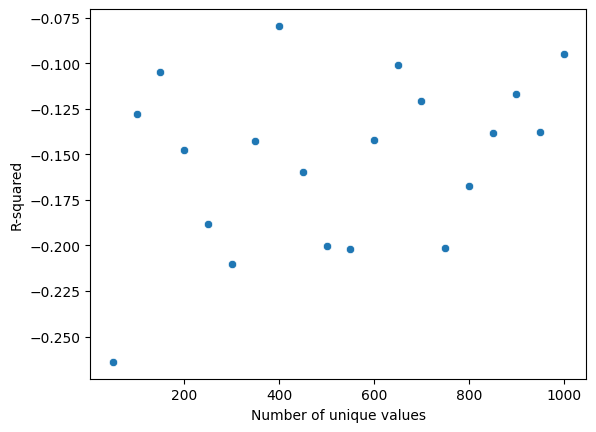

In [ ]:
sns.scatterplot(data=var_reconstructions, x=var_reconstructions.index, y='R-squared')
plt.xlabel('Number of unique values')